LOAD AND PREPROCESSING

In [22]:
import pandas as pd

#LOAD DATASET
df = pd.read_csv("data_customer_lifetime_value.csv")

#MISSING VALUE
df = df.dropna()

#ENCODE CATEGORY
df_encoded = pd.get_dummies(df, drop_first=True)
from sklearn.preprocessing import StandardScaler

#NORMALIZE
scaler = StandardScaler()
numeric_cols = ['Income', 'Monthly Premium Auto', 'Total Claim Amount', 'Number of Policies']
df_encoded[numeric_cols] = scaler.fit_transform(df_encoded[numeric_cols])

#SAVE THE SCALER
import joblib
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

DATA SPLIT

In [23]:
from sklearn.model_selection import train_test_split

#DEFINE X & Y
X = df_encoded.drop("Customer Lifetime Value", axis=1)
y = df_encoded["Customer Lifetime Value"]

# SAVE FEATURE NAMES for Streamlit alignment
import joblib
joblib.dump(X.columns.tolist(), 'model_features.pkl')

#SPLIT
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

REGRESSION TRAINING

In [24]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import numpy as np

#RANDOM FOREST
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

#XGBOOST
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

#AVERAGING & WRAPPING
from sklearn.base import BaseEstimator, RegressorMixin

class AveragingModel(BaseEstimator, RegressorMixin):
    def __init__(self, model1, model2):
        self.model1 = model1
        self.model2 = model2

    def fit(self, X, y):
        self.model1.fit(X, y)
        self.model2.fit(X, y)
        return self

    def predict(self, X):
        pred1 = self.model1.predict(X)
        pred2 = self.model2.predict(X)
        return (pred1 + pred2) / 2

#TRAIN & SAVE
ensemble_model = AveragingModel(rf, xgb)
ensemble_model.fit(X_train, y_train)
joblib.dump(ensemble_model, 'clv_predictor_model.pkl')

['clv_predictor_model.pkl']

EVALUATION

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#EVALUATE THE AVERAGE PREDICTION
y_pred = ensemble_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R2 Score: {r2}")

MSE: 15743018.804662846
MAE: 1721.8883126532571
R2 Score: 0.6445478503611494


INTERPRETATION

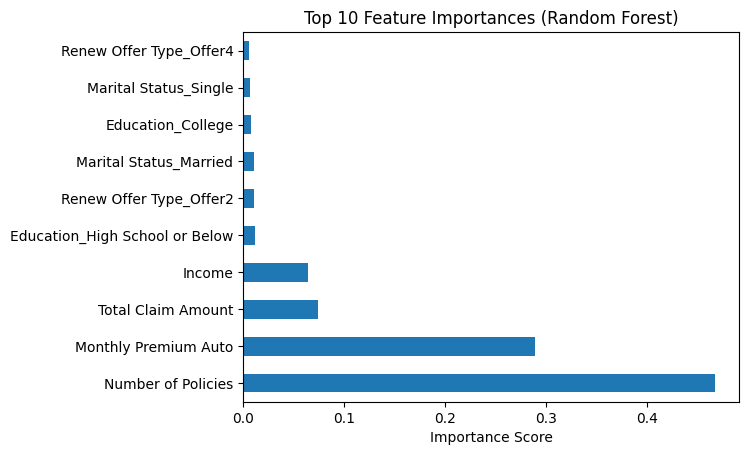

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#IMPORTANCE BY RANDOMFOREST
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.show()

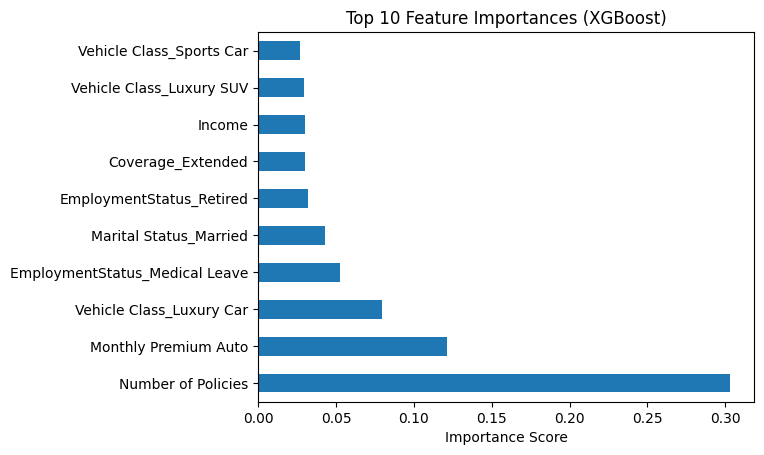

In [27]:
#IMPORTANCE BY XGBOOST
feat_importances = pd.Series(xgb.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Feature Importances (XGBoost)")
plt.xlabel("Importance Score")
plt.show()

NEXT: MAKE STREAMLIT FOR INPUT